In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [20]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
K = 3
MCMC_SIZE = 10
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 500
NUM_HIDDEN = 32
NUM_NSS = 16
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
DEVICE = 0

RECON_SIGMA = torch.ones(1) * 0.3
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'ag-phase4'

In [21]:
from global_oneshot_mu import *
from global_enc_mu import *
from local_gibbs_state import *
from local_enc_angle import *
from True_decoder import *
# initialization
oneshot_mu = Oneshot_mu_angle(K, D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
enc_mu = Enc_mu(D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
gibbs_state = Gibbs_state(K, CUDA, DEVICE)
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(RADI, RECON_SIGMA, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        oneshot_mu.cuda()
        enc_mu.cuda()
        enc_angle.cuda()
#         gibbs_state.cuda()
#         dec_x.cuda()
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(enc_mu.parameters())+list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

models = (oneshot_mu, gibbs_state, enc_mu, enc_angle, dec_x)

In [22]:
enc_angle.load_state_dict(torch.load('../results/enc-angle-' + PATH))
oneshot_mu.load_state_dict(torch.load('../results/oneshot-mu-' + PATH))
enc_mu.load_state_dict(torch.load('../results/enc-mu-' + PATH))

In [ ]:
from ag_ep_dec import *
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    ELBO = 0.0
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob = ob.cuda()
        eubo, elbo, ess = AG_dec(models, ob, K, MCMC_SIZE, DEVICE)
        eubo.backward()
        optimizer.step()                     
        ELBO += elbo.detach()
        EUBO += eubo.detach()
        ESS += ess
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

In [ ]:
# torch.save(enc_angle.state_dict(), '../results/enc-angle-' + PATH)
# torch.save(oneshot_mu.state_dict(), '../results/oneshot-mu-' + PATH)
# torch.save(enc_mu.state_dict(), '../results/enc-mu-' + PATH)

In [18]:
def plot_samples(ob, mu, state, K, PATH):
    colors = ['r', 'b', 'g', 'm', 'y']
    fig = plt.figure(figsize=(25,20))
    B, N, D = ob.shape
    for b in range(B):
        ax = fig.add_subplot(int(B / 5), 5, b+1)
        assignments = state[b].argmax(-1)
        for k in range(K):
            ob_k = ob[b][np.where(assignments == k)]
            ax.scatter(ob_k[:, 0], ob_k[:, 1], c=colors[k], alpha=0.8)
            ax.set_ylim([-12, 12])
            ax.set_xlim([-12, 12])
            ax.scatter(mu[b, k, 0], mu[b, k, 1], c=colors[k])
#     plt.savefig('../results/modes-' + PATH + '.svg')

In [5]:
from forward_backward_dec import *
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        ob = ob.cuda()
(oneshot_mu, gibbs_state, enc_mu, enc_angle, dec_x) = models
state, angle, mu, w, eubo, elbo, _, _ = oneshot(oneshot_mu, gibbs_state, dec_x, ob, K)
for m in range(MCMC_SIZE):
    if m == 0:
        state = resample(state, w, idw_flag=False) ## resample state
    else:
        state = resample(state, w_state, idw_flag=True)
    ## update mu
    mu, w_mu, eubo_mu, elbo_mu, q_mu, _  = Update_mu(enc_mu, dec_x, ob, state, angle, mu, K)
    mu = resample(mu, w_mu, idw_flag=True)
    ##update angle
    angle, w_angle, eubo_angle, elbo_angle, q_angle, _ = Update_angle(enc_angle, dec_x, ob, state, mu, angle)
    angle = resample(angle, w_angle, idw_flag=True)
    ## update z
    state, w_state, eubo_state, elbo_state, q_state, _ = Update_state(gibbs_state, dec_x, ob, angle, mu, state)
    


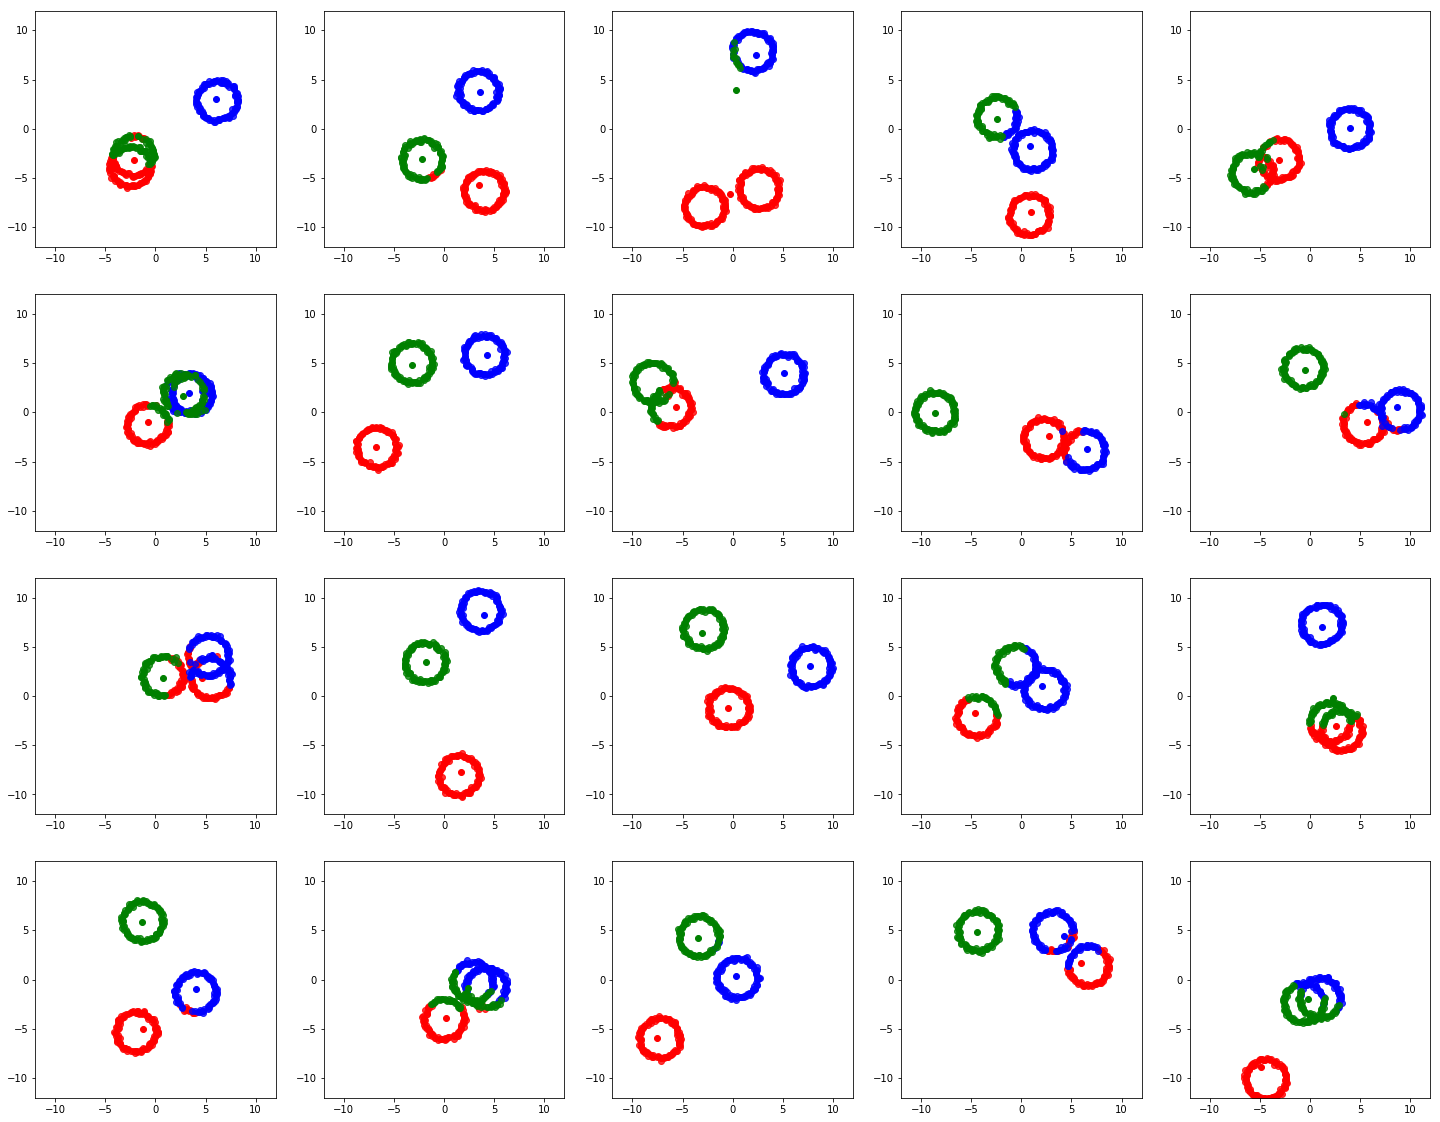

In [19]:
E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
E_state = q_state['zs'].dist.probs[0].cpu().data.numpy()
test_ob = ob[0].cpu().data.numpy()

plot_samples(test_ob, E_mu, E_state, K, PATH)